This notebook runs all the code to create the data for the analysis of mentions for causes of death in the media

It can be run as part of the [OWID etl repository](https://github.com/owid/etl) or locally on your own machine. Changes in code between these two versions are clearly marked. 

In [145]:
import datetime as dt
from pathlib import Path
import click
import mediacloud.api
import pandas as pd
from query_generation import create_full_queries, create_queries, create_single_keyword_queries
import time
import matplotlib.pyplot as plt

# these are only needed if you run this as part of the OWID etl
from etl.snapshot import Snapshot


ImportError: cannot import name 'create_single_keyword_queries' from 'query_generation' (/Users/tunaacisu/Code/etl/replication/media_deaths/query_generation.py)

## Set overall variables for analysis

There are some parameters you need to set before the analysis can be run:
- VERBOSE: If True, the script will output some information on its progress and intermediary results
- RERUN_QUERIES: If True, the Media Cloud API will be queried to get the article counts (mentions) for each cause of death. You will need to set a Media Cloud API key below. If False, this script will use the saved results in <code> ./data/media_death_mentions.csv </code>. 
- OVERWRITE: If True, this overwrites the saved results with your own results.

In [ ]:
YEAR = 2023
VERBOSE = True
RERUN_QUERIES = False # whether you want to rerun the queries or not - rerunning the queries can take ~30 minutes. If false, this uses the results found in ./data/media_deaths_mentions
OVERWRITE = False # whether you want to overwrite existing files or not

# These are the causes of death we are using for the 2023 version.
# They are based on the 12 leading causes of death in the US for 2023, plus drug overdoses, homicides, and terrorism
CAUSES_OF_DEATH = [
    "heart disease",
    "cancer",
    "accidents",
    "stroke",
    "respiratory",
    "alzheimers",
    "diabetes",
    "kidney",
    "liver",
    "covid",
    "suicide",
    "influenza",
    "drug overdose",
    "homicide",
    "terrorism",
]

TERRORISM_DEATHS_2023 = 16 # We get the terrorism deaths for the USA from the Global Terrorism Index

## Get deaths for each cause of death

This data comes from two files, both downloaded from the CDC Wonder database "[Underlying Cause of Death Data](https://wonder.cdc.gov/deaths-by-underlying-cause.html)". 
- The leading causes file is the result when selecting "Group results by" - "15 leading causes of death" and selecting the year 2023
- The external factors file is the result when selecting "Group result by" - "Cause of death", selecting the year 2023 and only selecting cause of death "V01-Y89 (External causes of mobidity and mortality)"

In [ ]:
# 15 leading causes of death
leading_causes_df = pd.read_csv("./data/Underlying Cause of Death_2023.csv")

# We map the names the CDC uses to our key words used in this analysis
CAUSES_MAP = {
    "#Diseases of heart (I00-I09,I11,I13,I20-I51)": "heart disease",
    "#Malignant neoplasms (C00-C97)": "cancer",
    "#Accidents (unintentional injuries) (V01-X59,Y85-Y86)": "accidents",
    "#Cerebrovascular diseases (I60-I69)": "stroke",
    "#Chronic lower respiratory diseases (J40-J47)": "respiratory",
    "#Alzheimer disease (G30)": "alzheimers",
    "#Diabetes mellitus (E10-E14)": "diabetes",
    "#Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)": "kidney",
    "#Chronic liver disease and cirrhosis (K70,K73-K74)": "liver",
    "#COVID-19 (U07.1)": "covid",
    "#Intentional self-harm (suicide) (*U03,X60-X84,Y87.0)": "suicide",
    "#Influenza and pneumonia (J09-J18)": "influenza",
    "#Essential hypertension and hypertensive renal disease (I10,I12,I15)": "hypertension",
    "#Septicemia (A40-A41)": "septicemia",
    "#Parkinson disease (G20-G21)": "parkinson",
}


leading_causes_df["cause"] = leading_causes_df["15 Leading Causes of Death"].map(CAUSES_MAP)
leading_causes_df = leading_causes_df.drop(columns=["Notes", "Population", "15 Leading Causes of Death", "15 Leading Causes of Death Code", "Crude Rate"], errors="raise")
leading_causes_df = leading_causes_df.dropna(subset=["cause", "Deaths"], how="all")
leading_causes_df["year"] = 2023

In [ ]:
# external causes (for homicide and drug overdoses)

external_causes_df = pd.read_csv("./data/Underlying Cause of Death_2023_external_factors.csv")

# replace Suppressed (causes with less than 10 deaths this year)/ Unreliable with pd.NA
external_causes_df = external_causes_df.replace("Suppressed", pd.NA)
external_causes_df = external_causes_df.replace("Unreliable", pd.NA)

external_causes_df["Deaths"] = external_causes_df["Deaths"].astype("Int64")
external_causes_df = external_causes_df.drop(columns=["Notes", "Population", "ICD Sub-Chapter Code"], errors="raise")

external_causes_df["year"] = 2023

In [ ]:
# Combining both dataframes and adding terrorism deaths

def create_tb_death(tb_leading_causes, tb_ext_causes):
    drug_od_deaths = tb_ext_causes[tb_ext_causes["Cause of death Code"] == "X42"]["Deaths"].iloc[0]
    ext_causes_gb = tb_ext_causes[["Deaths", "ICD Sub-Chapter"]].groupby("ICD Sub-Chapter").sum().reset_index()
    homicide_deaths = ext_causes_gb[ext_causes_gb["ICD Sub-Chapter"] == "Assault"]["Deaths"].iloc[0]

    terrorism_deaths = TERRORISM_DEATHS_2023

    deaths = [
        {"cause": "drug overdose", "year": 2023, "deaths": drug_od_deaths},
        {"cause": "homicide", "year": 2023, "deaths": homicide_deaths},
        {"cause": "terrorism", "year": 2023, "deaths": terrorism_deaths},
    ]

    tb_leading_causes.columns = [col.lower() for col in tb_leading_causes.columns]

    tb_death = pd.concat([tb_leading_causes, pd.DataFrame(deaths)])

    return tb_death

death_df = create_tb_death(leading_causes_df, external_causes_df)

## Get Media Mentions from Media Cloud
To get the number of articles that mention each cause of death for three major newspapers (the New York Times, the Washington Post and Fox News) we use the open-source database [Media Cloud](https://www.mediacloud.org/). 

Before you can run this code you need to create a free account on Media Cloud [here](https://search.mediacloud.org/sign-up) and create an [API token](https://github.com/mediacloud/api-tutorial-notebooks/blob/main/MC01%20-%20setup.ipynb). This API token should be pasted below, so you can access the database.

In [ ]:
#TODO remove this part:
from dotenv import load_dotenv
import os

load_dotenv()

MC_API_TOKEN = os.getenv("MC_API_TOKEN") #paste your API TOKEN here e.g. "46971fa7d873b615238234a777c2d867fbbb444b" - this is NOT a valid token
search_api = mediacloud.api.SearchApi(MC_API_TOKEN)

# source IDs for each newspaper
NYT_ID = 1
WAPO_ID = 2
FOX_ID = 1092
US_COLLECTION_ID = 34412234

# create queries - see query_generation.py
QUERIES = create_queries()
STR_QUERIES = create_full_queries()
SINGLE_QUERIES = create_single_keyword_queries()

In [ ]:
def get_start_end(year):
    return (dt.date(year, 1, 1), dt.date(year, 12, 31))

# helper function to use Media Cloud API
def query_results(query, source_ids, year, collection_ids=None):
    start_date, end_date = get_start_end(year)
    if collection_ids:
        results = search_api.story_count(
            query=query, start_date=start_date, end_date=end_date, collection_ids=collection_ids
        )
    else:
        results = search_api.story_count(query=query, start_date=start_date, end_date=end_date, source_ids=source_ids)
    return results["relevant"]

# function to get mentions from a specific source
def get_mentions_from_source(
    source_ids: list,
    source_name: str,
    queries: dict,
    year=YEAR,
    collection_ids=None,
):
    """
    Get mentions of causes of death from a specific source.
    Args:
        source_ids (list): List of source IDs to query.
        source_name (str): Name of the source.
        queries (dict): Dictionary of queries to run.
        year (int): Year to query for.
        collection_ids (list): List of collection IDs to query.
    Returns:
        pd.DataFrame: DataFrame containing the results of the queries."""
    query_count = []
    for name, query in queries.items():
        time.sleep(30) # wait for 30 seconds to avoid hitting API rate limits
        start_time = time.time()
        cnt = query_results(query, source_ids, collection_ids=collection_ids, year=year)
        if VERBOSE:
            print(f"Querying: {source_name} for CoD {name}")
            print(f"Query: {query}")
            print(f"Count: {cnt} mentions for {name} in the {source_name} in {year} - retrieved in {time.time() - start_time:.2f} seconds")
            print("-" * 40)
        query_count.append(
            {
                "cause": name,
                "mentions": cnt,
                "source": source_name,
                "year": year,
            }
        )
    return pd.DataFrame(query_count)


In [ ]:
if RERUN_QUERIES:
    assert MC_API_TOKEN is not None, "Get API key from https://www.mediacloud.org/ in order to access this data"
    source_ids = [NYT_ID, WAPO_ID, FOX_ID]
    sources = ["The New York Times", "The Washington Post", "Fox News"]

    mentions_ls = []

    queries_in_use = {q: q_str for q, q_str in STR_QUERIES.items() if q in CAUSES_OF_DEATH}

    for s_id, s_name in zip(source_ids, sources):
        mentions = get_mentions_from_source([s_id], s_name, queries_in_use, year=YEAR)
        mentions_ls.append(mentions.copy(deep=True))

    # add mentions for US collection
    collection_mentions = get_mentions_from_source(
        source_ids=[],
        source_name="US Collection",
        queries=queries_in_use,
        year=YEAR,
        collection_ids=[US_COLLECTION_ID],
    )
    mentions_ls.append(collection_mentions.copy(deep=True))

    # concatenate all mentions into a single DataFrame
    mentions_df = pd.concat(mentions_ls, ignore_index=True)
    if OVERWRITE:
        mentions_df.to_csv("./data/media_deaths_mentions.csv", index=False)

# to save time, you can use the cached version
else:
    tb_mentions = pd.read_csv("./data/media_deaths_mentions.csv")

In [ ]:
mentions_df.head()

,cause,mentions,source,year,mentions_share,deaths_share
0,heart disease,436,The New York Times,2023,0.0,0.0
1,cancer,625,The New York Times,2023,0.0,0.0
2,accidents,1489,The New York Times,2023,0.0,0.0
3,stroke,119,The New York Times,2023,0.0,0.0
4,respiratory,212,The New York Times,2023,0.0,0.0


## Analysis of results

In [ ]:
# these are some helper functions for the analysis:
def add_shares(tb, columns=None):
    """Add shares for each row relative to total of a columns to DataFrame."""
    if columns is None:
        columns = ["mentions", "deaths"]

    for col in columns:
        total = tb[col].sum()
        if total == 0:
            tb.loc[:, f"{col}_share"] = 0
        else:
            tb.loc[:, f"{col}_share"] = round(
                (tb[col] / total) * 100, 3
            )  # convert to percentage, round to three decimal places

    return tb


def plot_media_deaths(media_deaths_df, columns=None, bar_labels=None, title=None):
    """This function plots the final results. Colors are fixed for each cause of death.
    media_deaths_df: DataFrame containing media deaths data
    columns: List of columns to plot (default: ["deaths_share", "mentions_share"])
    bar_labels: List of labels for the bars (default: ["Deaths", "Mentions"])
    title: Title of the plot (default: "Media Mentions of Causes of Death in 2023")
    """

    fixed_colors = {
        "heart disease": "#1f77b4",  # Blue
        "cancer": "#ff7f0e",  # Orange
        "accidents": "#2ca02c",  # Green
        "stroke": "#d62728",  # Red
        "respiratory": "#9467bd",  # Purple
        "alzheimers": "#8c564b",  # Brown
        "diabetes": "#e377c2",  # Pink
        "kidney": "#7f7f7f",  # Gray
        "liver": "#bcbd22",  # Olive
        "covid": "#17becf",  # Teal
        "suicide": "#aec7e8",  # Light blue
        "influenza": "#ffbb78",  # Light orange
        "drug overdose": "#98df8a",  # Light green
        "homicide": "#ff9896",  # Light red
        "terrorism": "#c5b0d5",  # Light purple
        "war": "#c49c94",  # Light brown
        "hiv": "#f7b6d2",  # Light pink
        "malaria": "#c7c7c7",  # Light gray
        "tb": "#dbdb8d",  # Light olive
        "diarrhea": "#9edae5",  # Light teal
    }

    if columns is None:
        columns = ["deaths_share", "mentions_share"]
        bar_labels = ["Deaths", "Mentions"]
    if bar_labels is None:
        bar_labels = columns  # fallback to original column names
    if title is None:
        title = f"Media Mentions of Causes of Death in {YEAR}"

    mm_plot = media_deaths_df[["cause"] + columns].transpose()
    mm_plot.columns = mm_plot.iloc[0]
    mm_plot = mm_plot.drop(mm_plot.index[0])  # drop the first row which is the cause names
    mm_plot.index = bar_labels

    ordered_cols = [cause for cause in CAUSES_OF_DEATH if cause in mm_plot.columns]

    # Ensure the causes in mm_plot.columns match the fixed color order
    color_order = [fixed_colors[cause] for cause in ordered_cols]

    # Plot with fixed colors and cause order
    mm_plot = mm_plot[ordered_cols]  # Reorder the columns in desired order
    ax = mm_plot.plot(kind="bar", stacked=True, color=color_order)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    plt.ylabel("Share")
    plt.title(title)
    plt.legend(title="Cause of death", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()

    for i, row in enumerate(mm_plot.values):
        cumulative = 0
        for j, value in enumerate(row):
            if value > 2:
                ax.text(
                    x=i,  # bar index (x position)
                    y=cumulative + value / 2,  # vertical position in the middle of the bar segment
                    s=f"{round(value, 1)}%",  # label with one decimal place as percent
                    ha="center",
                    va="center",
                    fontsize=8,
                )
            cumulative += value

    plt.show()


In [ ]:
# printing death and media mentions dataframes to remember their structure
if VERBOSE:
    print("Dataframe containing death data:")
    print(death_df.head())
    print("Dataframe containing media mentions data:")
    print(mentions_df.head())

Dataframe containing death data:
   deaths          cause  year
0  680981  heart disease  2023
1  613352         cancer  2023
2  222698      accidents  2023
3  162639         stroke  2023
4  145357    respiratory  2023
Dataframe containing media mentions data:
           cause  mentions              source  year  mentions_share  \
0  heart disease       436  The New York Times  2023             0.0   
1         cancer       625  The New York Times  2023             0.0   
2      accidents      1489  The New York Times  2023             0.0   
3         stroke       119  The New York Times  2023             0.0   
4    respiratory       212  The New York Times  2023             0.0   

   deaths_share  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  


In [ ]:
# analysis
# copy existing df into new dataframes to make rerunning cells easier
tb_mentions = mentions_df.copy(deep=True)
tb_deaths = death_df.copy(deep=True)

# filter only on causes of death we are interested in
tb_mentions = tb_mentions[tb_mentions["cause"].isin(CAUSES_OF_DEATH)] #type:ignore

tb_mentions= pd.merge(left=tb_mentions, right=tb_deaths, on=["cause", "year"], how="left")

sources = tb_mentions["source"].unique().tolist() #type:ignore

# add shares to media mentions table
tb_mentions.loc[:, "mentions_share"] = 0.0
tb_mentions.loc[:, "deaths_share"] = 0.0
for source in sources:
    tb_s = tb_mentions[tb_mentions["source"] == source]
    tb_s = add_shares(tb_s, columns=["mentions", "deaths"])
    tb_mentions.update(tb_s)

# pivot table
tb_mentions = tb_mentions.pivot(
        index=["cause", "year", "deaths", "deaths_share"], columns="source", values=["mentions", "mentions_share"]
    ).reset_index()

tb_mentions.columns = [
        "cause",
        "year",
        "deaths",
        "deaths_share",
        "fox_mentions",
        "nyt_mentions",
        "wapo_mentions",
        "us_mentions",
        "fox_share",
        "nyt_share",
        "wapo_share",
        "us_share",
    ]


## Plotting the results

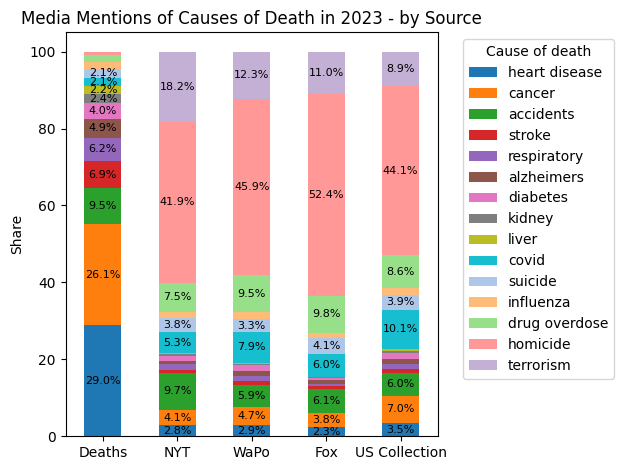

In [ ]:
plot_media_deaths(tb_mentions, columns=["deaths_share", "nyt_share", "wapo_share", "fox_share", "us_share"], bar_labels=["Deaths", "NYT", "WaPo", "Fox", "US Collection"], title=f"Media Mentions of Causes of Death in {YEAR} - by Source")